# Deteksi Spam untuk Teks Bahasa Indonesia

## Daftar Isi
1. [Pendahuluan](#Pendahuluan)
2. [Memuat dan Memahami Data](#Memuat-dan-Memahami-Data)
3. [Preprocessing Data](#Preprocessing-Data)
4. [Label Encoding](#Label-Encoding)
5. [Feature Engineering](#Feature-Extraction)
6. [Train-Test Split](#Train-Test-Split)
7. [Pemodelan](#Pemodelan)
8. [Perbandingan Model](#Perbandingan-Model)
9. [Pembuatan Model](#Pembuatan-Model)
10. [Testing Model](#Testing-Model)

# Pendahuluan

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
import json
import swifter
import pickle

# Untuk preprocessing teks bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Untuk model machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Untuk deep learning (MLP)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Memuat dan Memahami Data

Contoh 10 data pertama:

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ulasan    15000 non-null  object
 1   kategori  15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB

Statistik Deskriptif:

Distribusi Kategori:


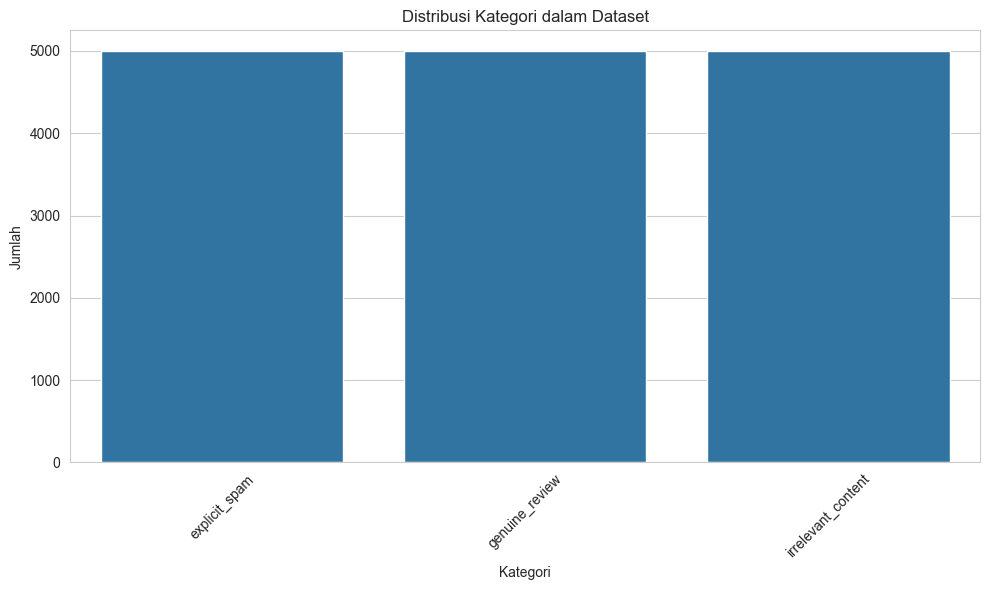

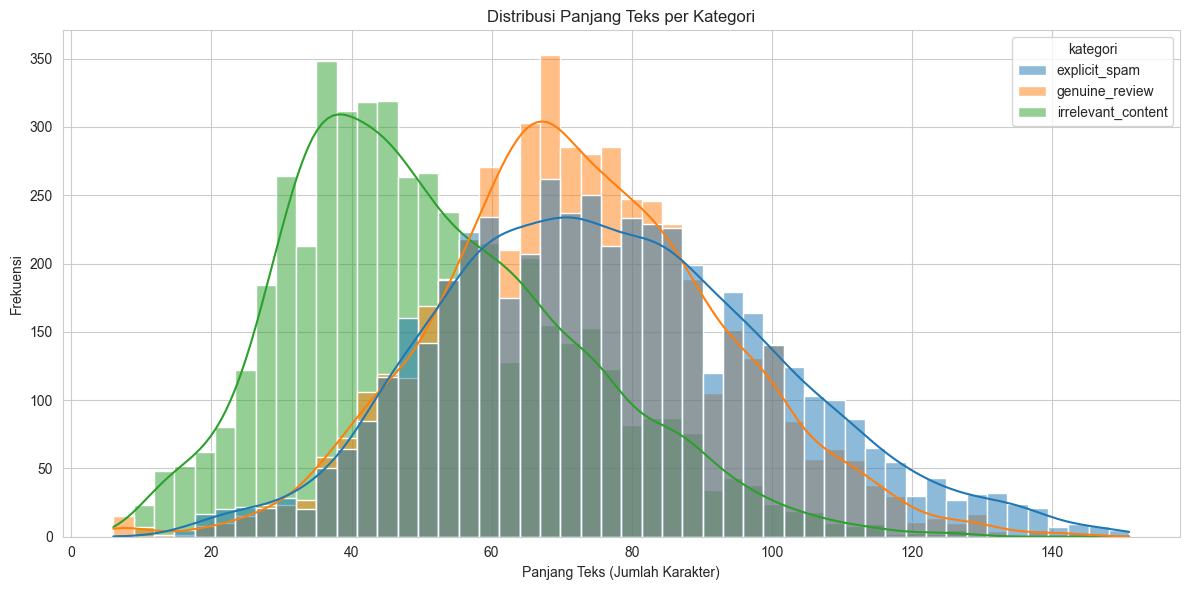


Statistik Panjang Teks per Kategori:


,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
explicit_spam,5000.0,76.8092,23.865438,15.0,60.0,75.0,93.0,151.0
genuine_review,5000.0,72.4922,20.476626,6.0,59.0,71.0,86.0,145.0
irrelevant_content,5000.0,51.4580,20.421480,6.0,36.0,48.0,65.0,129.0


In [6]:
# Load dataset
df = pd.read_csv('../main_dataset/Spam Dataset/dataset_main.csv')

# Melihat 10 data pertama
print("Contoh 10 data pertama:")
df.head(10)

# Informasi dataset
print("\nInformasi Dataset:")
df.info()

# Statistik deskriptif
print("\nStatistik Deskriptif:")
df.describe()

# Melihat distribusi kategori
print("\nDistribusi Kategori:")
df['kategori'].value_counts()

# Visualisasi distribusi kategori
plt.figure(figsize=(10, 6))
sns.countplot(x='kategori', data=df)
plt.title('Distribusi Kategori dalam Dataset')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analisis panjang teks
df['panjang_teks'] = df['ulasan'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='panjang_teks', hue='kategori', bins=50, kde=True)
plt.title('Distribusi Panjang Teks per Kategori')
plt.xlabel('Panjang Teks (Jumlah Karakter)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Statistik panjang teks per kategori
print("\nStatistik Panjang Teks per Kategori:")
df.groupby('kategori')['panjang_teks'].describe()

# Preprocessing Data

## 3.1 Membaca data slang dan stopwords

In [7]:
print("Memuat kamus slang dan stopwords...")

# Load kamus slang
with open('../slang/merged_slang_dict.json', 'r', encoding='utf-8') as file:
    slang_dict = json.load(file)

# Load stopwords
with open('../stopwords/stopwords_indonesia.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

Memuat kamus slang dan stopwords...


## 3.2 Fungsi preprocessing

In [10]:
def preprocess_text(text, slang_dict=slang_dict, stopwords=stopwords):
    """
    Fungsi untuk melakukan preprocessing pada teks bahasa Indonesia
    """
    # Ubah ke lowercase
    text = text.lower()
    
    # Hapus URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Hapus karakter non-alfanumerik
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Koreksi kata slang
    words = text.split()
    corrected_words = []
    
    for word in words:
        if word in slang_dict:
            corrected_words.append(slang_dict[word])
        else:
            corrected_words.append(word)
    
    # Gabungkan kata-kata
    corrected_text = ' '.join(corrected_words)
    
    # Hapus stopwords
    factory = StopWordRemoverFactory()
    stopword_remover = factory.create_stop_word_remover()
    text_without_stopwords = stopword_remover.remove(corrected_text)
    
    # Stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_text = stemmer.stem(text_without_stopwords)
    
    return stemmed_text

# Terapkan preprocessing pada ulasan
print("Menerapkan preprocessing pada data...")
df['clean_text'] = df['ulasan'].swifter.apply(preprocess_text)

# Tampilkan beberapa contoh hasil preprocessing
print("\nContoh Hasil Preprocessing:")
pd.set_option('display.max_colwidth', None)
sample_df = df[['ulasan', 'clean_text', 'kategori']].sample(5)
sample_df

Menerapkan preprocessing pada data...


Pandas Apply: 100%|██████████| 15000/15000 [35:13<00:00,  7.10it/s] 


Contoh Hasil Preprocessing:


,ulasan,clean_text,kategori
13340,ulasan saya tentang review film horor siksa kubur di google maps kok hilang ya?,ulas tentang ulas film horor siksa kubur google maps kok hilang iya,irrelevant_content
14944,"izin share info ya admin, video kucing lucu",izin bagi informasi iya admin video kucing lucu,irrelevant_content
752,ini software buatan asia ya?,software buat asia iya,irrelevant_content
14912,kenapa ya fitur keyframe animation kok menghapus data tanpa konfirmasi? padahal sebelumnya lancar?,iya fitur keyframe animation kok hapus data konfirmasi padahal belum lancar,genuine_review
11637,murah! https://goo.gl/spamxyz,murah,explicit_spam


In [23]:
# Tampilkan beberapa contoh hasil preprocessing
print("\nContoh Hasil Preprocessing:")
pd.set_option('display.max_colwidth', None)
sample_df = df[['ulasan', 'clean_text', 'kategori']].sample(5)
sample_df


Contoh Hasil Preprocessing:


,ulasan,clean_text,kategori
10246,"saya pakai spotify premium dari developer meta, fiturnya beda jauh ternyata",pakai spotify premium developer meta fiturnya beda jauh nyata,irrelevant_content
4326,gak masuk akal! jangan download mobile legends bang bang,masuk akal jangan unduh seluler legenda bang bang,explicit_spam
12768,"di sumatera utara pakai wifi indihome lancar agak lag kalau sinyal jelek, integrasi google docs mulus",sumatra utara pakai wifi indihome lancar lag kalau sinyal jelek integrasi google docs mulus,genuine_review
2265,"proses proses saving berjalan agak lambat, perlu sabar",proses proses saving jalan lambat perlu sabar,genuine_review
11238,jual makanan ringan di bali,jual makan ringan bal,irrelevant_content


# Label Encoding

In [24]:
print("Melakukan Label Encoding...")
label_mapping = {
    'genuine_review': 0,
    'irrelevant_content': 1,
    'explicit_spam': 2  
}

df['label'] = df['kategori'].map(label_mapping)

# Tampilkan distribusi label hasil encoding
print("\nDistribusi Label Setelah Encoding:")
df['label'].value_counts()

Melakukan Label Encoding...

Distribusi Label Setelah Encoding:


label
2    5000
0    5000
1    5000
Name: count, dtype: int64

# Feature Extraction

In [26]:
print("Melakukan Feature Extraction dengan TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

print(f"Dimensi fitur TF-IDF: {X_tfidf.shape}")

Melakukan Feature Extraction dengan TF-IDF...
Dimensi fitur TF-IDF: (15000, 5000)


# Train-Test Split

In [27]:
print("Melakukan pemisahan data training dan testing...")
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

print(f"Jumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")

Melakukan pemisahan data training dan testing...
Jumlah data training: 12000
Jumlah data testing: 3000


# Pemodelan

## Model Naive Bayes


Training dan Evaluasi Model Naive Bayes...

Hasil Evaluasi Model Naive Bayes:
Akurasi: 0.9850

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1000
           1       0.99      0.97      0.98      1000
           2       0.99      0.99      0.99      1000

    accuracy                           0.98      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.98      0.99      3000



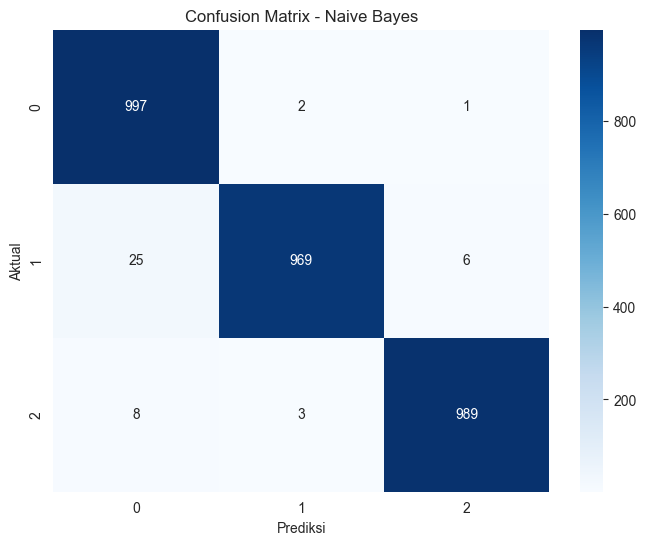

In [28]:
print("\nTraining dan Evaluasi Model Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Prediksi
y_pred_nb = nb_model.predict(X_test)

# Evaluasi
print("\nHasil Evaluasi Model Naive Bayes:")
print(f"Akurasi: {accuracy_score(y_test, y_pred_nb):.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

## Model SVM


6.2 Training dan Evaluasi Model SVM...

Hasil Evaluasi Model SVM:
Akurasi: 0.9983

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



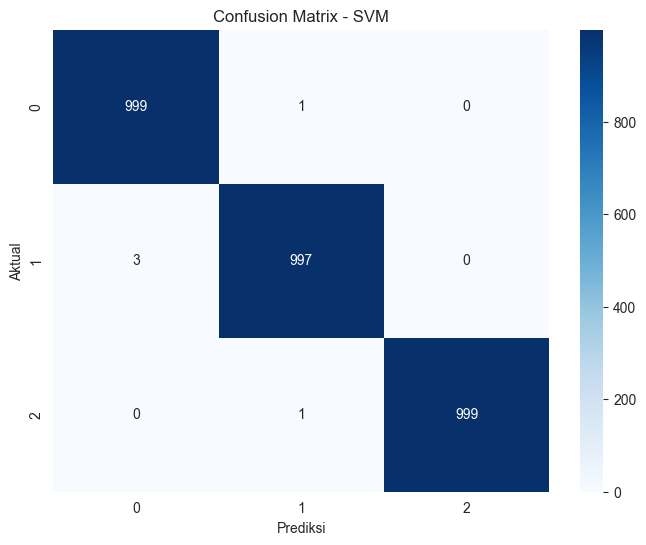

In [29]:
print("\n6.2 Training dan Evaluasi Model SVM...")
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Prediksi
y_pred_svm = svm_model.predict(X_test)

# Evaluasi
print("\nHasil Evaluasi Model SVM:")
print(f"Akurasi: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

## Model MLP dengan PyTorch


6.3 Training dan Evaluasi Model MLP dengan PyTorch...
Epoch [1/10], Loss: 0.3784, Accuracy: 0.9017
Epoch [2/10], Loss: 0.0116, Accuracy: 0.9977
Epoch [3/10], Loss: 0.0045, Accuracy: 0.9990
Epoch [4/10], Loss: 0.0027, Accuracy: 0.9993
Epoch [5/10], Loss: 0.0018, Accuracy: 0.9996
Epoch [6/10], Loss: 0.0013, Accuracy: 0.9997
Epoch [7/10], Loss: 0.0011, Accuracy: 0.9996
Epoch [8/10], Loss: 0.0010, Accuracy: 0.9996
Epoch [9/10], Loss: 0.0009, Accuracy: 0.9997
Epoch [10/10], Loss: 0.0010, Accuracy: 0.9997

Hasil Evaluasi Model MLP:
Akurasi: 0.9973

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



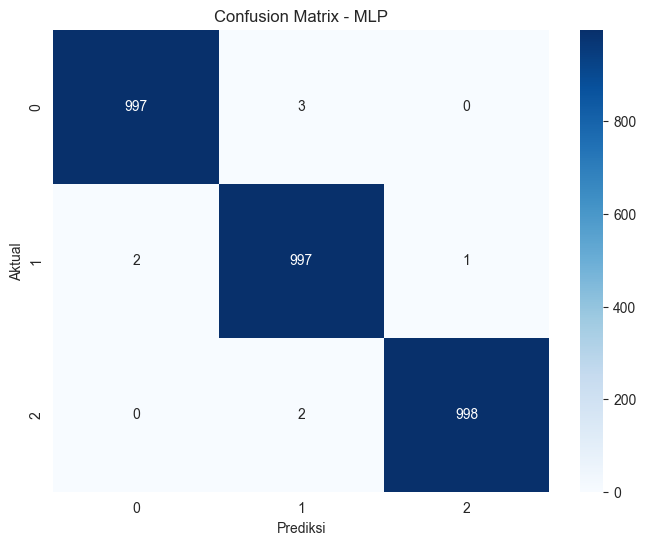

In [30]:
print("\n6.3 Training dan Evaluasi Model MLP dengan PyTorch...")

# Konversi data sparse ke numpy array
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Konversi data ke tensor
X_train_tensor = torch.FloatTensor(X_train_dense)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_dense)
y_test_tensor = torch.LongTensor(y_test.values)

# Dataset dan DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definisi model MLP
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Inisialisasi model
input_size = X_train_dense.shape[1]
hidden_size = 128
output_size = 3 

model = MLPClassifier(input_size, hidden_size, output_size)

# Definisi loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

# Evaluasi model
model.eval()
y_pred_mlp = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred_mlp.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Evaluasi
print("\nHasil Evaluasi Model MLP:")
print(f"Akurasi: {accuracy_score(y_true, y_pred_mlp):.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_true, y_pred_mlp))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_mlp = confusion_matrix(y_true, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MLP')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

# Perbandingan Model

Perbandingan Performa Model:


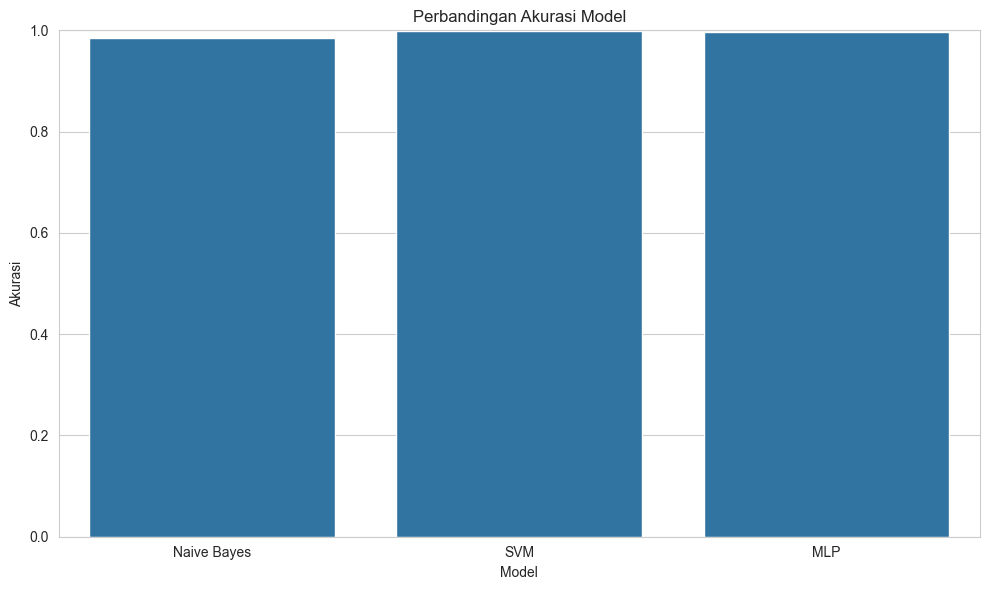

In [31]:
# Buat tabel perbandingan
models = ['Naive Bayes', 'SVM', 'MLP']
accuracy = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_true, y_pred_mlp)
]

comparison_df = pd.DataFrame({
    'Model': models,
    'Akurasi': accuracy
})

print("Perbandingan Performa Model:")
comparison_df

# Visualisasi perbandingan
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Akurasi', data=comparison_df)
plt.title('Perbandingan Akurasi Model')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Pembuatan Model

In [43]:
# 8.1 Pembuatan Pipeline untuk Feature Extraction
feature_extraction_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer)  # Gunakan instance yang sama yang sudah dilatih sebelumnya
])

# 8.2 Fungsi untuk Reverse Label Mapping
def reverse_label_mapping(label):
    reverse_mapping = {
        0: 'genuine_review', 
        1: 'irrelevant_content', 
        2: 'explicit_spam'
    }
    return reverse_mapping[label]

# 8.3 Fungsi untuk memprediksi dengan model Naive Bayes
def predict_with_nb(text, feature_pipeline, model):
    # Preprocess teks
    preprocessed_text = preprocess_text(text)
    
    # Ekstraksi fitur
    features = feature_pipeline.transform([preprocessed_text])
    
    # Prediksi
    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0]
    
    return {
        'label': prediction,
        'category': reverse_label_mapping(prediction),
        'probability': max(probability)
    }

# 8.4 Fungsi untuk memprediksi dengan model SVM
def predict_with_mlp(text, feature_pipeline, model):
    # Preprocess teks
    preprocessed_text = preprocess_text(text)
    
    # Ekstraksi fitur
    features = feature_pipeline.transform([preprocessed_text])
    
    # Konversi ke tensor dan pindahkan ke perangkat yang sama dengan model
    device = next(model.parameters()).device  # Ambil device dari model
    features_tensor = torch.FloatTensor(features.toarray()).to(device)
    
    # Prediksi
    model.eval()
    with torch.no_grad():
        outputs = model(features_tensor)
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.softmax(outputs, dim=1)
    
    prediction = predicted.item()
    probability = probabilities[0][prediction].item()
    
    return {
        'label': prediction,
        'category': reverse_label_mapping(prediction),
        'probability': probability
    }

# 8.5 Fungsi untuk memprediksi dengan model MLP

model = model.to('cpu')

def predict_with_mlp(text, feature_pipeline, model):
    # Preprocess teks
    preprocessed_text = preprocess_text(text)
    
    # Ekstraksi fitur
    features = feature_pipeline.transform([preprocessed_text])
    
    # Konversi ke tensor
    features_tensor = torch.FloatTensor(features.toarray())
    
    # Pindahkan ke GPU jika model di GPU
    if next(model.parameters()).is_cuda:
        features_tensor = features_tensor.cuda()
    
    # Prediksi
    model.eval()
    with torch.no_grad():
        outputs = model(features_tensor)
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.softmax(outputs, dim=1)
    
    prediction = predicted.cpu().item()  # Pindahkan kembali ke CPU untuk item()
    probability = probabilities[0][prediction].cpu().item()
    
    return {
        'label': prediction,
        'category': reverse_label_mapping(prediction),
        'probability': probability
    }

# Fit feature extraction pipeline
feature_extraction_pipeline.fit(df['clean_text'])

print("\nMenyimpan model dan pipeline ke folder Pipeline...")

# Buat direktori Pipeline jika belum ada
import os
if not os.path.exists('../Pipeline'):
    os.makedirs('../Pipeline')

# Simpan model Naive Bayes
with open('../Pipeline/naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

# Simpan model SVM
with open('../Pipeline/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# Simpan model MLP
torch.save(model.state_dict(), '../Pipeline/mlp_model.pth')

# Simpan pipeline
with open('../Pipeline/feature_extraction_pipeline.pkl', 'wb') as f:
    pickle.dump(feature_extraction_pipeline, f)

print("Model dan pipeline berhasil disimpan di folder Pipeline!")


Menyimpan model dan pipeline ke folder Pipeline...
Model dan pipeline berhasil disimpan di folder Pipeline!


# Testing Model

In [44]:
# Array untuk sampel komentar
samples = [
    "Aplikasinya sangat membantu untuk mengedit foto.",
    "Bagaimana kabar hari ini?",
    "Dapatkan voucher gratis kode ABC123 sekarang!",
    "aneh",
    "semua urusan lebih gampang banget dengan gopay",
    "bayar pake gopay semua jadi lebih murah",
    "Cepat di acc",
    "Min ah kacau bet saya mau login gopay ulang karena HP keriset malah suruh vermuk yg dimna muka itu punya temen jauh saya jdi kgk bisa login gimna nih buset dh klo gini crnya ilang akun gopay saya",
    "Semoga gratis selama nya yaaaa",
    "saya sangat senang transaksi pakai gopai karena gak ribet.",
    "layanan yang cukup memuaskan",
    "Fasilitas yg sangat mudah",
    "Via tf sesama gopay nya lelet bgttt , tolong perbaikin minðŸ™�",
    "yang baru belajar uang digital, Gopay mempermudah transaksi banget siðŸ«°",
    "Bagus bisa juga buat bayar greb bike",
    "moga di GoPay tidak ada Hacker seperti di akun Dana",
    "kenapa tiba ngelag banget sampai ga bisa melakukan pembayaran, padahal kuota saya full dan bisa membuka aplikasi yang lain. tolong diperbaiki",
    "ok. dan simple",
    "Faster and Better... ðŸ«° Okey deh..",
    "Sangat puas sekali dan menguntungkan dan bikinnyaman dan aman sentosa... terimakasih gopay..",
    "Baguss & cepat",
    "Cepat buat transver",
    "Aplikasinya bagus banget, fiturnya lengkap dan mudah dipakai!",
    "DISKON BESAR!! Klik link ini segera bit.ly/promo123 jangan sampai kehabisan!",
    "Min, kok app nya sering force close ya di hp saya? Tolong diperbaiki.",
    "Jual pulsa murah WA 081234567890",
    "Hari ini cuaca cerah sekali.",
    "Gamenya seru tapi iklannya banyak banget mengganggu.",
    "Saya tidak mengerti cara menggunakan fitur X, bisa tolong jelaskan?",
    "Mantap jiwaaaaaa 👍👍👍👍👍",
    "qwerty asdfgh zxcvb",
    "Lebih bagus dari aplikasi sebelah yg lemot itu.",
    "joki mobile legends hanya di http://ourastore.com ASIKKK"
]

if samples:
    for i, sample in enumerate(samples):
        print(f"\nSampel {i+1}: {sample}")
        
        # Prediksi dengan Naive Bayes
        nb_result = predict_with_nb(sample, feature_extraction_pipeline, nb_model)
        print(f"Naive Bayes - Kategori: {nb_result['category']}, Probabilitas: {nb_result['probability']:.4f}")
        
        # Prediksi dengan SVM
        svm_result = predict_with_svm(sample, feature_extraction_pipeline, svm_model)
        print(f"SVM - Kategori: {svm_result['category']}, Probabilitas: {svm_result['probability']:.4f}")
        
        # Prediksi dengan MLP
        mlp_result = predict_with_mlp(sample, feature_extraction_pipeline, model)
        print(f"MLP - Kategori: {mlp_result['category']}, Probabilitas: {mlp_result['probability']:.4f}")


Sampel 1: Aplikasinya sangat membantu untuk mengedit foto.
Naive Bayes - Kategori: genuine_review, Probabilitas: 0.8855
SVM - Kategori: genuine_review, Probabilitas: 0.9909
MLP - Kategori: genuine_review, Probabilitas: 0.9964

Sampel 2: Bagaimana kabar hari ini?
Naive Bayes - Kategori: irrelevant_content, Probabilitas: 0.7923
SVM - Kategori: irrelevant_content, Probabilitas: 0.9976
MLP - Kategori: irrelevant_content, Probabilitas: 0.9994

Sampel 3: Dapatkan voucher gratis kode ABC123 sekarang!
Naive Bayes - Kategori: explicit_spam, Probabilitas: 0.9197
SVM - Kategori: explicit_spam, Probabilitas: 0.5803
MLP - Kategori: explicit_spam, Probabilitas: 0.6550

Sampel 4: aneh
Naive Bayes - Kategori: genuine_review, Probabilitas: 0.4763
SVM - Kategori: irrelevant_content, Probabilitas: 0.7443
MLP - Kategori: irrelevant_content, Probabilitas: 0.8878

Sampel 5: semua urusan lebih gampang banget dengan gopay
Naive Bayes - Kategori: irrelevant_content, Probabilitas: 0.5335
SVM - Kategori: irrele